# Kaggle Kickstarter Projectでのロジスティック回帰

・KaggleURL
https://www.kaggle.com/kemical/kickstarter-projects

# 目的
Kickstarter Project（クラウドファンディング）が成功するかどうかを分類できるモデルを生成する

# 目標
分類のAccuracy目標を80%以上をクライアントから要求されたと仮定する

# 全体の流れ
全体の流れは以下の通りとする
1. データセットを調べる
2. データの読み込み
3. 前処理を行う
4. 特徴量を選択する
5. モデルを学習・評価する
6. まとめ
7. 課題


# 戦略概要

前処理
* 事後でないと分からないデータは除く
* 文字列から数値化できる変数を生成する
* カテゴリなどの質的変数はダミー変数化する

特徴量選択
* LASSOによる特徴選択する（DAY3）

モデル
* 木モデルを追加する（DAY3）
* ニューラルネットワークを追加する（DAY3）

評価
* 汎化誤差を比較する
* ホールドアウト法、交差検証法で評価する

試してみること
* nameの頻出単語を調べる
* 異常値、外れ値がないか調べる
* ドメイン知識として、クラウドファンディングは終了間際に一気に伸びる傾向があるため、締切日の曜日を使用する  


# 講師DAY3アドバイス（全体）
* 標準化や正規化は、train_test_splitした後
* 正則化係数やSVMのCなどのハイパーパラメータは、適切な値を探索
* グリッドサーチを行うときは、候補値の範囲や間隔が適切かどうかをよく検討
* 手法どうしを汎化誤差で比較する場合は、用いるテストデータなどの条件を揃える
* サンプリングしたデータで学習する場合、まず、全学習データをtrainとtestにわけ、そのtarinの中から1%とか5%を抜き出して学習
* 次回DAY4は、通し課題の最終発表を行います。皆さんの取り組み結果を同じ土俵で比較したいので、最終のAccuracyは、以下の条件におけるX_testおよびy_testを用いた結果で評価する
* ターゲットエンコーディングもチャレンジしてみましょうCategoryEncoders

```
df = df[df['state'].isin(['failed','successful'])]
df["state"] = df["state"]=="successful"
X = df[***].values
y = df["state"].values
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size,
random_state=1234)
```




# 講師DAY3アドバイス（個別）
* name_lenとstateの関係グラフを比率で表示
* SGDClassifierのalphaを調整
* max_iter=1のところがあったので修正
* 標準化は、train_test_splitした後
* 訓練性能ではなく、汎化性能で評価

# 1.データセットを調べる
---
## データセット ks-projects-201801.csv

  * ID：内部ID
  * name：プロジェクト名
  * cetegory：カテゴリー
  * main_category：メインカテゴリー
  * currency：使用する通貨
  * deadline：締切日
  * goal：ゴール金額
  * launched：開始日
  * pledged：契約金額
  * state：プロジェクトの状態
  * backers：後援者数
  * country：国
  * usd pledged：契約金額（ドル換算）
  * usd_pledged_real：実質契約金額（ドル換算）
  * usd_goal_real：ゴール金額（ドル換算）




In [59]:
# ライブラリのインポート
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix
from  sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix # 回帰問題における性能評価に関する関数
from sklearn.preprocessing import StandardScaler
from sklearn.tree import  DecisionTreeClassifier
from sklearn.neighbors import  KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
#import xgboost as xgb
from tqdm import tqdm
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
from collections import Counter
import collections
from IPython.display import display
from sklearn.metrics import accuracy_score,f1_score,recall_score,precision_score,classification_report
from tensorflow import keras  
import tensorflow as tf

# 2.データの読み込み

CSVデータを読み込んで内容を眺めてみる

In [23]:
df_ks = pd.read_csv("ks-projects-201801.csv")

# 要約統計量
df_ks.describe(include='all')

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
count,3.786610e+05,378657,378661,378661,378661,378661,3.786610e+05,378661,3.786610e+05,378661,378661.000000,378661,3.748640e+05,3.786610e+05,3.786610e+05
unique,NaN,375764,159,15,14,3164,NaN,378089,NaN,6,NaN,23,NaN,NaN,NaN
top,NaN,New EP/Music Development,Product Design,Film & Video,USD,2014-08-08,NaN,1970-01-01 01:00:00,NaN,failed,NaN,US,NaN,NaN,NaN
freq,NaN,41,22314,63585,295365,705,NaN,7,NaN,197719,NaN,292627,NaN,NaN,NaN
mean,1.074731e+09,NaN,NaN,NaN,NaN,NaN,4.908079e+04,NaN,9.682979e+03,NaN,105.617476,NaN,7.036729e+03,9.058924e+03,4.545440e+04
std,6.190862e+08,NaN,NaN,NaN,NaN,NaN,1.183391e+06,NaN,9.563601e+04,NaN,907.185035,NaN,7.863975e+04,9.097334e+04,1.152950e+06
min,5.971000e+03,NaN,NaN,NaN,NaN,NaN,1.000000e-02,NaN,0.000000e+00,NaN,0.000000,NaN,0.000000e+00,0.000000e+00,1.000000e-02
25%,5.382635e+08,NaN,NaN,NaN,NaN,NaN,2.000000e+03,NaN,3.000000e+01,NaN,2.000000,NaN,1.698000e+01,3.100000e+01,2.000000e+03
50%,1.075276e+09,NaN,NaN,NaN,NaN,NaN,5.200000e+03,NaN,6.200000e+02,NaN,12.000000,NaN,3.947200e+02,6.243300e+02,5.500000e+03
75%,1.610149e+09,NaN,NaN,NaN,NaN,NaN,1.600000e+04,NaN,4.076000e+03,NaN,56.000000,NaN,3.034090e+03,4.050000e+03,1.550000e+04


In [24]:
# データの要約
df_ks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   ID                378661 non-null  int64  
 1   name              378657 non-null  object 
 2   category          378661 non-null  object 
 3   main_category     378661 non-null  object 
 4   currency          378661 non-null  object 
 5   deadline          378661 non-null  object 
 6   goal              378661 non-null  float64
 7   launched          378661 non-null  object 
 8   pledged           378661 non-null  float64
 9   state             378661 non-null  object 
 10  backers           378661 non-null  int64  
 11  country           378661 non-null  object 
 12  usd pledged       374864 non-null  float64
 13  usd_pledged_real  378661 non-null  float64
 14  usd_goal_real     378661 non-null  float64
dtypes: float64(5), int64(2), object(8)
memory usage: 43.3+ MB


**nameとusd pledged**に欠損値があることが分かる

#3.前処理を行う

データは378661行ある

stateをsuccessfulとfailedに絞り込み、sucessfulを1、failedを0とする'state_flag'を追加する

→**DAY4課題のフォーマットに合わせる**

In [25]:
# stateの状態を調べる
print(df_ks['state'].value_counts())

failed        197719
successful    133956
canceled       38779
undefined       3562
live            2799
suspended       1846
Name: state, dtype: int64


In [26]:
"""
# stateがsuccessful,failのものに絞り込む
df_ks = df_ks[df_ks['state'].str.contains("success") | df_ks['state'].str.contains("failed")]

# steteがsuccessfulの場合1、failの場合0とする
df_ks['state_flg'] = df_ks['state'].apply(lambda x : 1 if x == "successful" else 0)

print(df_ks['state_flg'].value_counts())
"""

# DAY4課題に合わせる
df_ks = df_ks[df_ks['state'].isin(['failed','successful'])]
df_ks["state"] = df_ks["state"]=="successful"


successfulが133956個、failedが197719個となっている

データの出現回数を調べる

In [27]:
df_ks.name.value_counts()

New EP/Music Development                 15
Music Video                              11
New EP / Music Development               10
Reflections                               9
Debut Album                               9
                                         ..
Off to discover & Photograph Europe..     1
One Flag                                  1
Grey Ambitions                            1
Felder Hoodie: iPhone                     1
Internet Your Thing                       1
Name: name, Length: 329594, dtype: int64

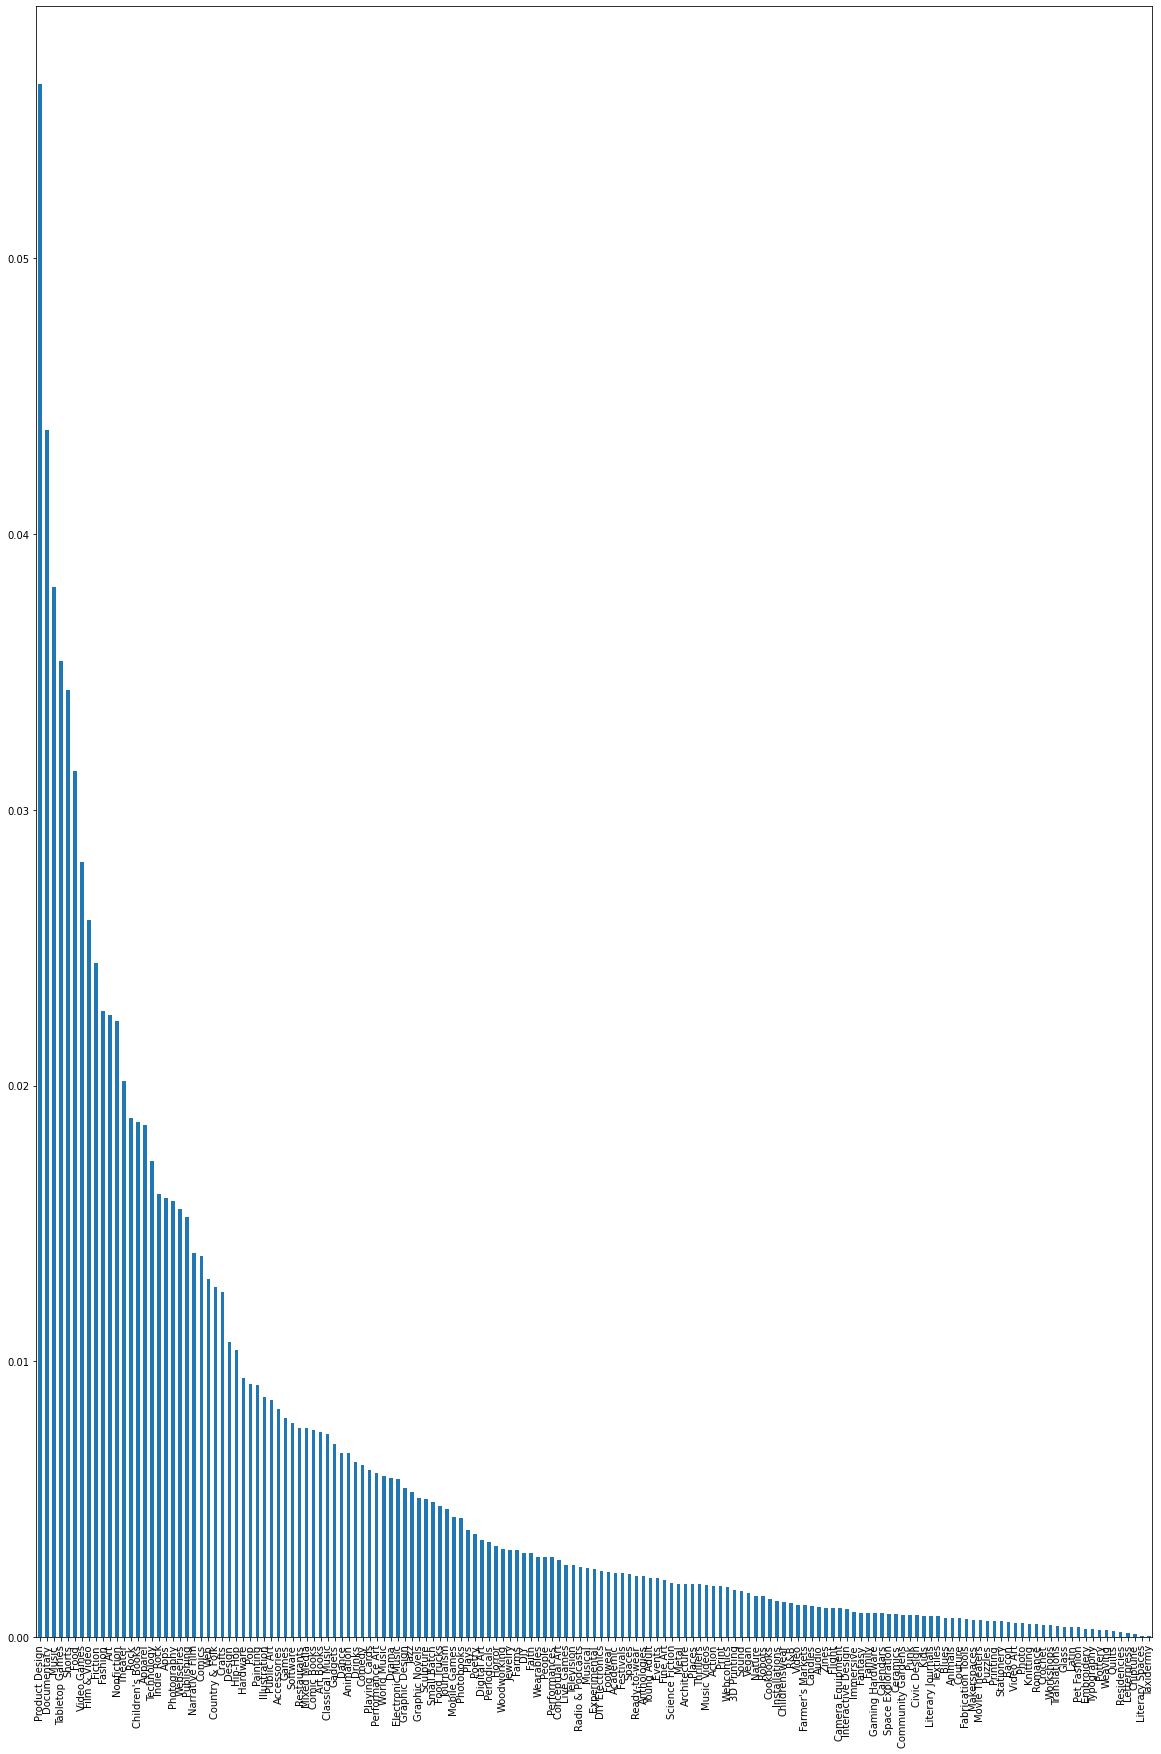

In [28]:
df_ks.category.value_counts(normalize=True).plot.bar(figsize=(20, 30))

Product Designが最も多いが、5％強なので、大きな偏りはなさそうである

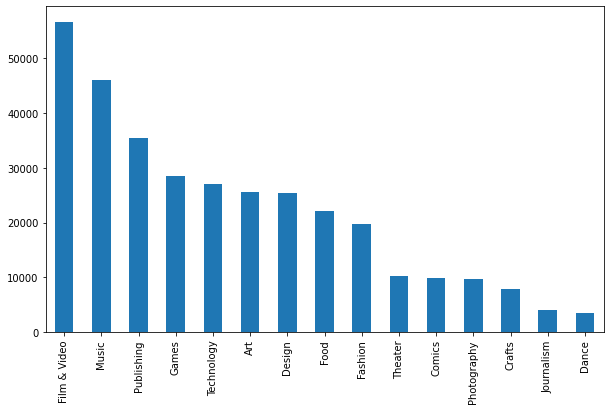

In [29]:
df_ks.main_category.value_counts().plot.bar(figsize=(10, 6))

main_categoryは特に異常は見られない

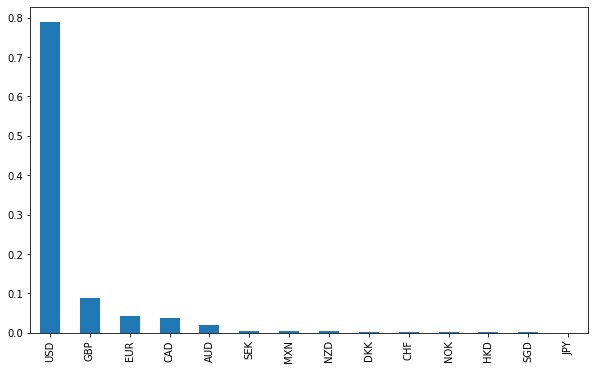

In [30]:
df_ks.currency.value_counts(normalize=True).plot.bar(figsize=(10, 6))

USDが80%近くと圧倒的に多い

In [31]:
df_ks.deadline.value_counts()

2014-08-08    612
2014-08-10    480
2014-08-07    460
2015-05-01    419
2014-08-09    396
             ... 
2009-06-17      1
2009-10-27      1
2009-07-30      1
2009-05-26      1
2009-09-28      1
Name: deadline, Length: 3102, dtype: int64

締切日に大きな特徴はなさそうである

In [32]:
df_ks.launched.value_counts()

2015-04-10 02:03:22    2
2012-05-21 23:55:48    2
2015-09-25 20:08:30    2
2014-07-08 19:55:03    2
2015-02-10 18:47:11    2
                      ..
2017-04-06 15:47:21    1
2016-05-28 03:01:42    1
2015-02-18 06:24:44    1
2016-05-02 18:34:56    1
2011-04-22 21:03:20    1
Name: launched, Length: 331255, dtype: int64

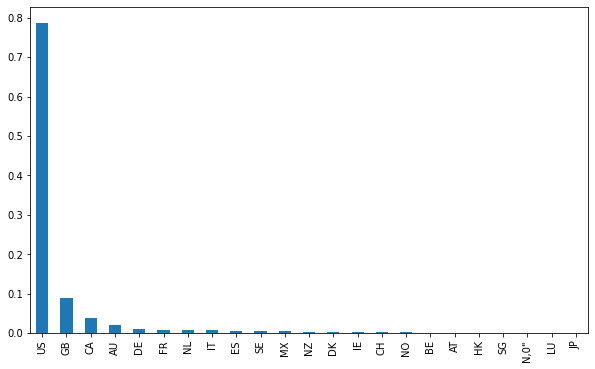

In [33]:
df_ks.country.value_counts(normalize=True).plot.bar(figsize=(10, 6))

USが80％近くと最も多く、N,0"は文字化けか不明な国のようである

In [34]:
df_ks.usd_goal_real.value_counts()

5000.00     21454
10000.00    18351
1000.00     11908
3000.00     11474
2000.00     10815
            ...  
2577.32         1
647.67          1
2132.35         1
4195.59         1
26681.49        1
Name: usd_goal_real, Length: 44651, dtype: int64

5000や10000などキリの良い数字が多いようである

## 文字数(name_len)を特徴量生成

nameが使えるかどうかを検討するために**文字数(name_len)とsuccessfullの関係**をグラフ化する

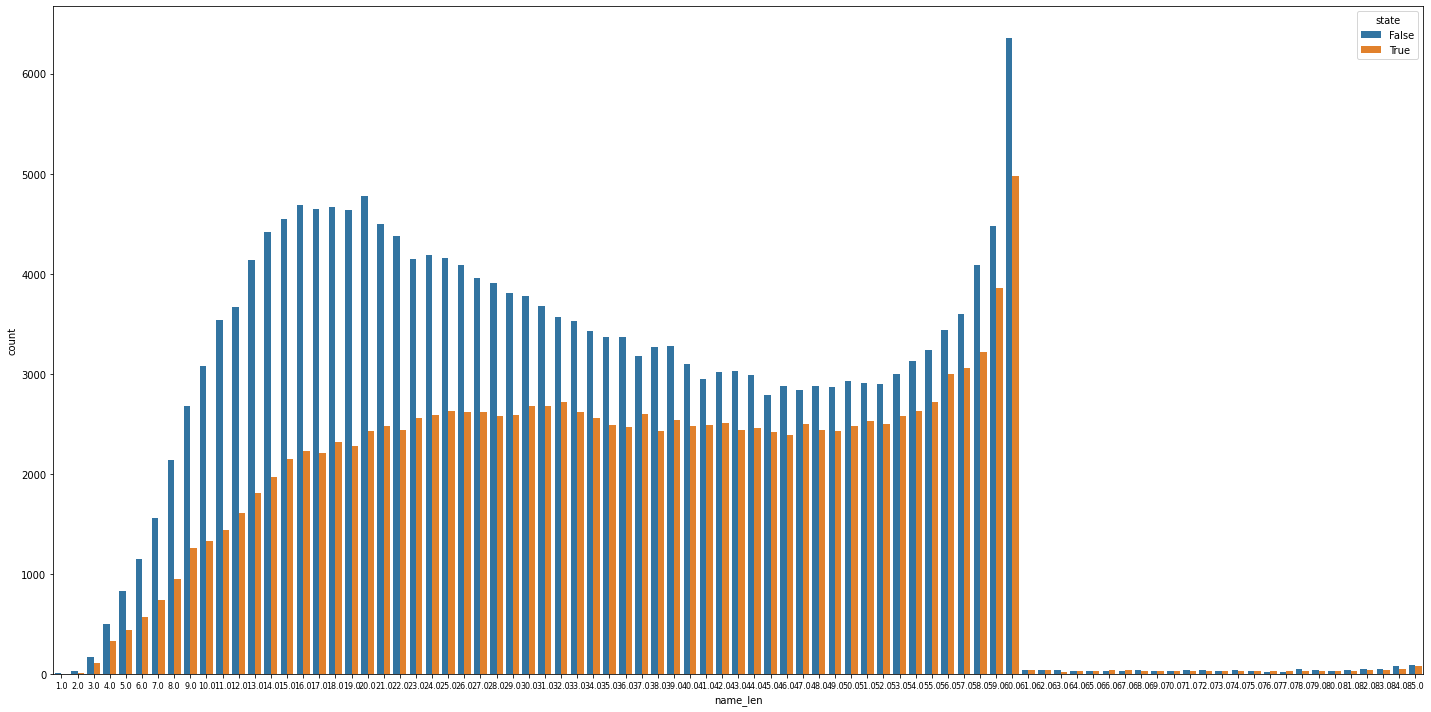

In [35]:
df_ks['name_len'] = df_ks.name.str.len()
plt.figure(figsize=(20,10))
ax = sns.countplot(data=df_ks, x='name_len',hue='state')
ax.set_xticklabels(ax.get_xticklabels(), fontsize=8)
plt.tight_layout()
plt.show()

文字数が10文字～20文字あたりはfailedの比率が大きく、40文字以上ではあまり差が見られない

## 単語数(word_count)を特徴量生成

英単語数を計算する

In [36]:
df_ks['word_count'] = df_ks['name'].str.split().str.len()

## 期間(period)を特徴量生成

開始日と終了日から**期間(period)**を取得する

In [37]:
df_ks["period"] = (pd.to_datetime(df_ks.deadline) - pd.to_datetime(df_ks.launched)).dt.days

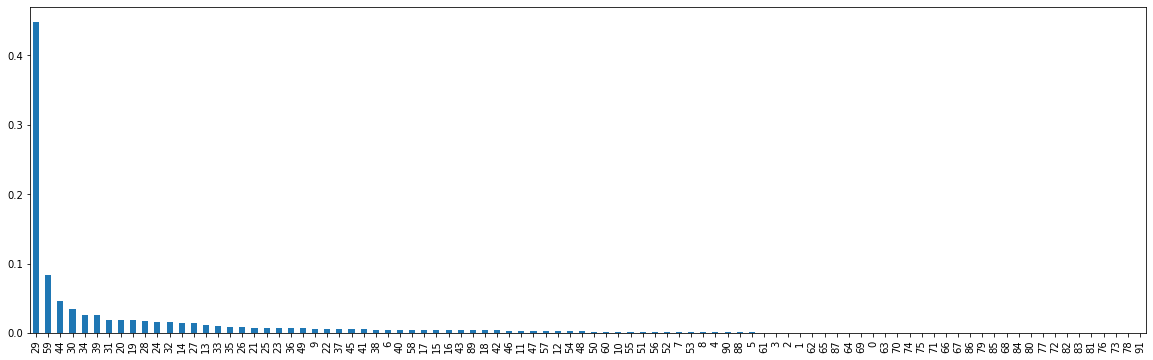

In [38]:
df_ks.period.value_counts(normalize=True).plot.bar(figsize=(20, 6))

29日が最も多く、1か月の募集ということが考えられる

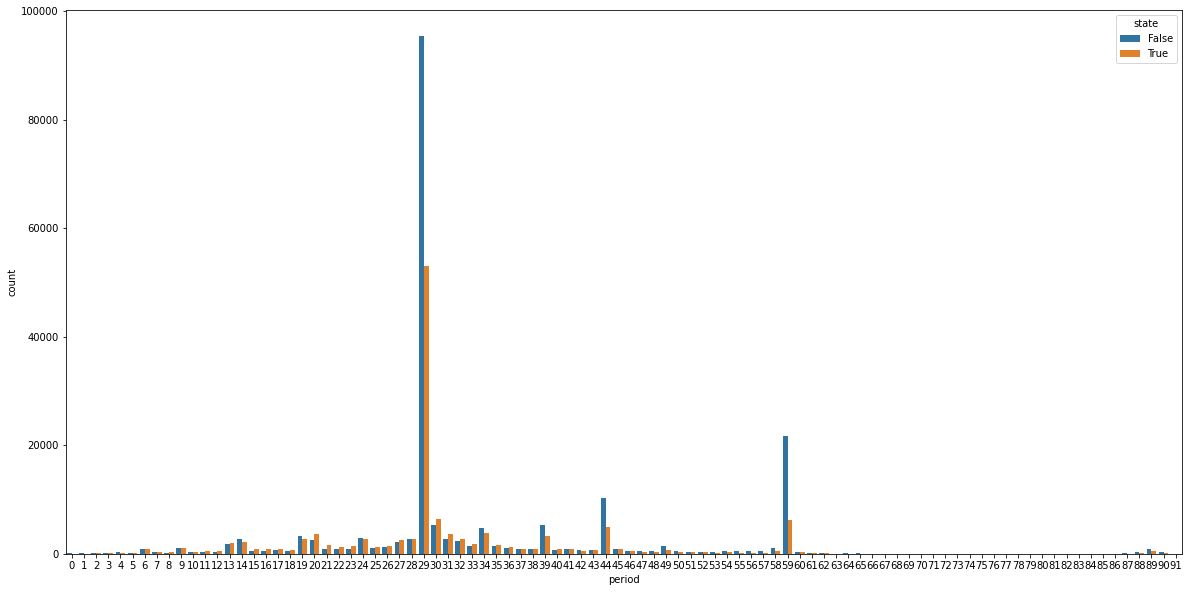

In [39]:
plt.figure(figsize=(20,10))
sns.countplot(data=df_ks, x='period',hue='state')

期間periodとstateの間にはあまり関連がありそうにない

## 開始日、締切日を年月日、曜日に分けて特徴量生成する

ドメイン知識として、クラウドファンディングは終了間際に一気に伸びる傾向がある  
そのため、終了日の曜日が結果に関連すると仮定する

開始日を年、月、日、時、曜日に分けて使用する

In [40]:
df_ks = df_ks.assign(l_hour=pd.to_datetime(df_ks.launched).dt.hour,
               l_day=pd.to_datetime(df_ks.launched).dt.day,
               l_month=pd.to_datetime(df_ks.launched).dt.month,
               l_year=pd.to_datetime(df_ks.launched).dt.year,
               l_weekday=pd.to_datetime(df_ks.launched).dt.strftime('%A'))

締切日を年、月、日、時、曜日に分けて使用する  
deadlineには時間がないので日付のみとする

In [41]:
df_ks = df_ks.assign(d_day=pd.to_datetime(df_ks.deadline).dt.day,
               d_month=pd.to_datetime(df_ks.deadline).dt.month,
               d_year=pd.to_datetime(df_ks.deadline).dt.year,
               d_weekday=pd.to_datetime(df_ks.deadline).dt.strftime('%A'))

#4.特徴量を選択する
回帰に不要な列（事後でないと分からない項目、同義の項目）を削除する

## 削除理由
* ID：インデックスのため
* name：name_lenで文字数を使用する
* currency：countryと同義
* deadlineとlaunched：period（期間)に代替
* pledged,backers,usd pledged,usd_pledged_real：事後でないと分からない
* goal：usd_goal_realでドル換算でそろえたものを使用
* state：state_flgで代替





In [42]:
# 関連しない項目
# 後にならないと分からない項目

drop_idx = ['ID', 'name', 'currency', 'deadline', 'launched', 'pledged', 'backers', 'usd pledged', 'usd_pledged_real', 'goal']
df_ks = df_ks.drop(drop_idx, axis=1)

df_ks.head()

,category,main_category,state,country,usd_goal_real,name_len,word_count,period,l_hour,l_day,l_month,l_year,l_weekday,d_day,d_month,d_year,d_weekday
0,Poetry,Publishing,False,GB,1533.95,31.0,6.0,58,12,11,8,2015,Tuesday,9,10,2015,Friday
1,Narrative Film,Film & Video,False,US,30000.00,45.0,8.0,59,4,2,9,2017,Saturday,1,11,2017,Wednesday
2,Narrative Film,Film & Video,False,US,45000.00,14.0,3.0,44,0,12,1,2013,Saturday,26,2,2013,Tuesday
3,Music,Music,False,US,5000.00,49.0,7.0,29,3,17,3,2012,Saturday,16,4,2012,Monday
5,Restaurants,Food,True,US,50000.00,20.0,3.0,34,13,26,2,2016,Friday,1,4,2016,Friday


文字列として、category,main_category,countryが残っている

In [43]:
# 欠損行を確認
df_ks.isnull().sum()

category         0
main_category    0
state            0
country          0
usd_goal_real    0
name_len         3
word_count       3
period           0
l_hour           0
l_day            0
l_month          0
l_year           0
l_weekday        0
d_day            0
d_month          0
d_year           0
d_weekday        0
dtype: int64

In [44]:
# 欠損行を削除
df_ks = df_ks.dropna()
df_ks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 331672 entries, 0 to 378660
Data columns (total 17 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   category       331672 non-null  object 
 1   main_category  331672 non-null  object 
 2   state          331672 non-null  bool   
 3   country        331672 non-null  object 
 4   usd_goal_real  331672 non-null  float64
 5   name_len       331672 non-null  float64
 6   word_count     331672 non-null  float64
 7   period         331672 non-null  int64  
 8   l_hour         331672 non-null  int64  
 9   l_day          331672 non-null  int64  
 10  l_month        331672 non-null  int64  
 11  l_year         331672 non-null  int64  
 12  l_weekday      331672 non-null  object 
 13  d_day          331672 non-null  int64  
 14  d_month        331672 non-null  int64  
 15  d_year         331672 non-null  int64  
 16  d_weekday      331672 non-null  object 
dtypes: bool(1), float64(3), int64

**改めてデータを眺めてみる**

現在の項目での相関を確認する

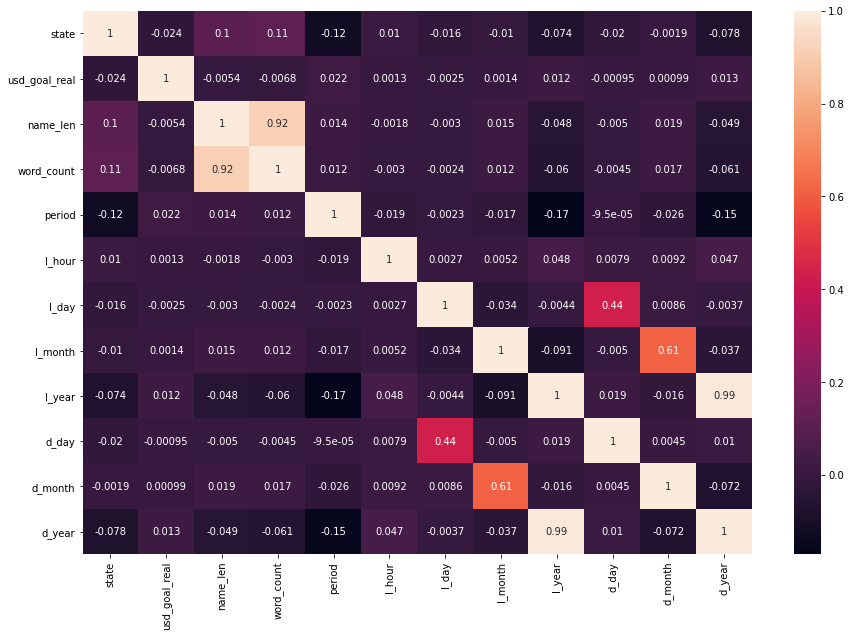

In [45]:
# 相関関係をヒートマップで確認
plt.figure(figsize=(15,10))
sns.heatmap(df_ks.corr(), annot=True)
plt.show()

* name_len,word_count,period,はstateと相関がありそう
* launchedを分割したhour、day、montyは相関がありそうだが、yearは相関が低い


文字列をダミー変数化して、説明変数として使用する

In [46]:
# 質的変数をダミー変数化
df_ks = pd.get_dummies(df_ks)
df_ks.describe()

,usd_goal_real,name_len,word_count,period,l_hour,l_day,l_month,l_year,d_day,d_month,d_year,category_3D Printing,category_Academic,category_Accessories,category_Action,category_Animals,category_Animation,category_Anthologies,category_Apparel,category_Apps,category_Architecture,category_Art,category_Art Books,category_Audio,category_Bacon,category_Blues,category_Calendars,category_Camera Equipment,category_Candles,category_Ceramics,category_Children's Books,category_Childrenswear,category_Chiptune,category_Civic Design,category_Classical Music,category_Comedy,category_Comic Books,category_Comics,category_Community Gardens,category_Conceptual Art,...,main_category_Publishing,main_category_Technology,main_category_Theater,country_AT,country_AU,country_BE,country_CA,country_CH,country_DE,country_DK,country_ES,country_FR,country_GB,country_HK,country_IE,country_IT,country_JP,country_LU,country_MX,"country_N,0""",country_NL,country_NO,country_NZ,country_SE,country_SG,country_US,l_weekday_Friday,l_weekday_Monday,l_weekday_Saturday,l_weekday_Sunday,l_weekday_Thursday,l_weekday_Tuesday,l_weekday_Wednesday,d_weekday_Friday,d_weekday_Monday,d_weekday_Saturday,d_weekday_Sunday,d_weekday_Thursday,d_weekday_Tuesday,d_weekday_Wednesday
count,3.316720e+05,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.00000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.00000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,...,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000
mean,4.150966e+04,34.220335,5.631027,32.954889,13.087336,15.285421,6.416149,2014.180024,15.271491,6.758499,2014.244543,0.001713,0.002343,0.008261,0.001872,0.000690,0.006672,0.002222,0.018591,0.015940,0.001936,0.02257,0.007444,0.001094,0.000546,0.000706,0.000874,0.001055,0.00114,0.000829,0.018687,0.001260,0.000099,0.000802,0.007357,0.006235,0.007516,0.013812,0.000817,0.002804,...,0.106868,0.081556,0.030880,0.001462,0.019947,0.001577,0.037296,0.001966,0.010360,0.002792,0.005647,0.007598,0.088802,0.001438,0.002059,0.007143,0.000069,0.000172,0.004254,0.000633,0.007269,0.001755,0.003841,0.004550,0.001369,0.788001,0.154810,0.161322,0.086088,0.055142,0.160125,0.204126,0.178387,0.163004,0.129728,0.158551,0.146768,0.158144,0.103648,0.140157
std,1.108935e+06,15.961502,2.757329,12.713279,7.715452,8.814433,3.306967,1.930916,9.038861,3.315179,1.919260,0.041347,0.048345,0.090515,0.043230,0.026267,0.081411,0.047087,0.135074,0.125245,0.043953,0.14853,0.085958,0.033064,0.023354,0.026552,0.029557,0.032468,0.03374,0.028783,0.135418,0.035478,0.009974,0.028308,0.085455,0.078716,0.086371,0.116710,0.028573,0.052878,...,0.308945,0.273688,0.172993,0.038212,0.139820,0.039678,0.189486,0.044294,0.101254,0.052765,0.074935,0.086834,0.284458,0.037896,0.045332,0.084212,0.008327,0.013108,0.065085,0.025155,0.084949,0.041853,0.061858,0.067298,0.036972,0.408724,0.361724,0.367828,0.280494,0.228257,0.366723,0.403062,0.382839,0.369370,0.336004,0.365258,0.353876,0.364877,0.304803,0.347150
min,1.000000e-02,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,2009.000000,1.000000,1.000000,2009.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0

# 学習用のデータに分ける

**※DEBUG　以下のコードはデータ量をサンプリングして試行錯誤を高速で試すためのコード（通常はコメントアウト）**

In [47]:
# 高速に試行錯誤するためにデータ数をサンプリングして試す（テストコード）
# df_ks = df_ks.sample(frac=0.01)

In [48]:
y = df_ks['state'].values
X = df_ks.drop('state', axis=1).values

## LASSOによる特徴選択

In [49]:
# estimatorにモデルをセット
# LassoCVを使って、正則化の強さは自動決定
estimator = LassoCV(normalize=True, cv=10)

# モデルの情報を使って特徴選択を行う場合は、SelectFromModelを使う
# 今回は係数が1e-5以下である特徴を削除する
# 係数のしきい値はthresholdで指定する
sfm = SelectFromModel(estimator, threshold=1e-5)

In [50]:
# fitで特徴選択を実行
sfm.fit(X, y)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.520320225390606, tolerance: 7.187580005025175
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.356779326408287, tolerance: 7.1854256263705
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.958875781543611, tolerance: 7.188711521080311
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increas

SelectFromModel(estimator=LassoCV(alphas=None, copy_X=True, cv=10, eps=0.001,
                                  fit_intercept=True, max_iter=1000,
                                  n_alphas=100, n_jobs=None, normalize=True,
                                  positive=False, precompute='auto',
                                  random_state=None, selection='cyclic',
                                  tol=0.0001, verbose=False),
                max_features=None, norm_order=1, prefit=False, threshold=1e-05)

In [51]:
train_label = df_ks["state"]
train_data = df_ks.drop('state', axis=1)

# 削除すべき特徴の名前を取得 
removed_idx  = ~sfm.get_support()
train_data.columns[removed_idx]

Index(['usd_goal_real', 'l_year', 'd_month', 'category_Children's Books',
       'category_Conceptual Art', 'category_Design', 'category_Jewelry',
       'category_Music Videos', 'category_Small Batch', 'category_Woodworking',
       'main_category_Film & Video', 'main_category_Games', 'country_LU',
       'country_SE', 'l_weekday_Thursday', 'd_weekday_Friday',
       'd_weekday_Wednesday'],
      dtype='object')

In [52]:
# LASSOで得た各特徴の係数の値を確認
# 係数の絶対値を取得
abs_coef = np.abs(sfm.estimator_.coef_)
abs_coef

array([7.08501877e-09, 1.29445656e-03, 9.36829318e-03, 4.49237675e-03,
       7.43781872e-04, 4.35591212e-04, 1.51453507e-03, 0.00000000e+00,
       5.32431817e-04, 7.69288351e-06, 8.99903516e-03, 1.01988083e-01,
       1.10728733e-01, 1.03161624e-01, 1.66128537e-01, 7.93840439e-02,
       6.07752561e-02, 2.47273393e-01, 4.30006885e-02, 2.12778207e-01,
       9.40850937e-02, 5.97298818e-02, 1.70234822e-01, 7.81582977e-02,
       1.15405423e-01, 1.00009747e-02, 6.51081587e-02, 2.17660220e-01,
       1.24898984e-01, 9.38747586e-02, 0.00000000e+00, 5.60310440e-02,
       2.99944217e-01, 3.30341868e-03, 1.72123690e-01, 6.22050166e-02,
       1.23499730e-01, 6.04095727e-03, 7.69004993e-02, 0.00000000e+00,
       4.21104356e-02, 1.61100950e-01, 8.68377360e-02, 5.55431772e-04,
       2.87012249e-02, 8.19697004e-02, 1.92936266e-01, 2.36691975e-01,
       0.00000000e+00, 6.94331163e-02, 2.65162799e-02, 7.30569552e-02,
       4.20333680e-02, 1.13581302e-01, 7.27090555e-02, 1.43610289e-01,
      

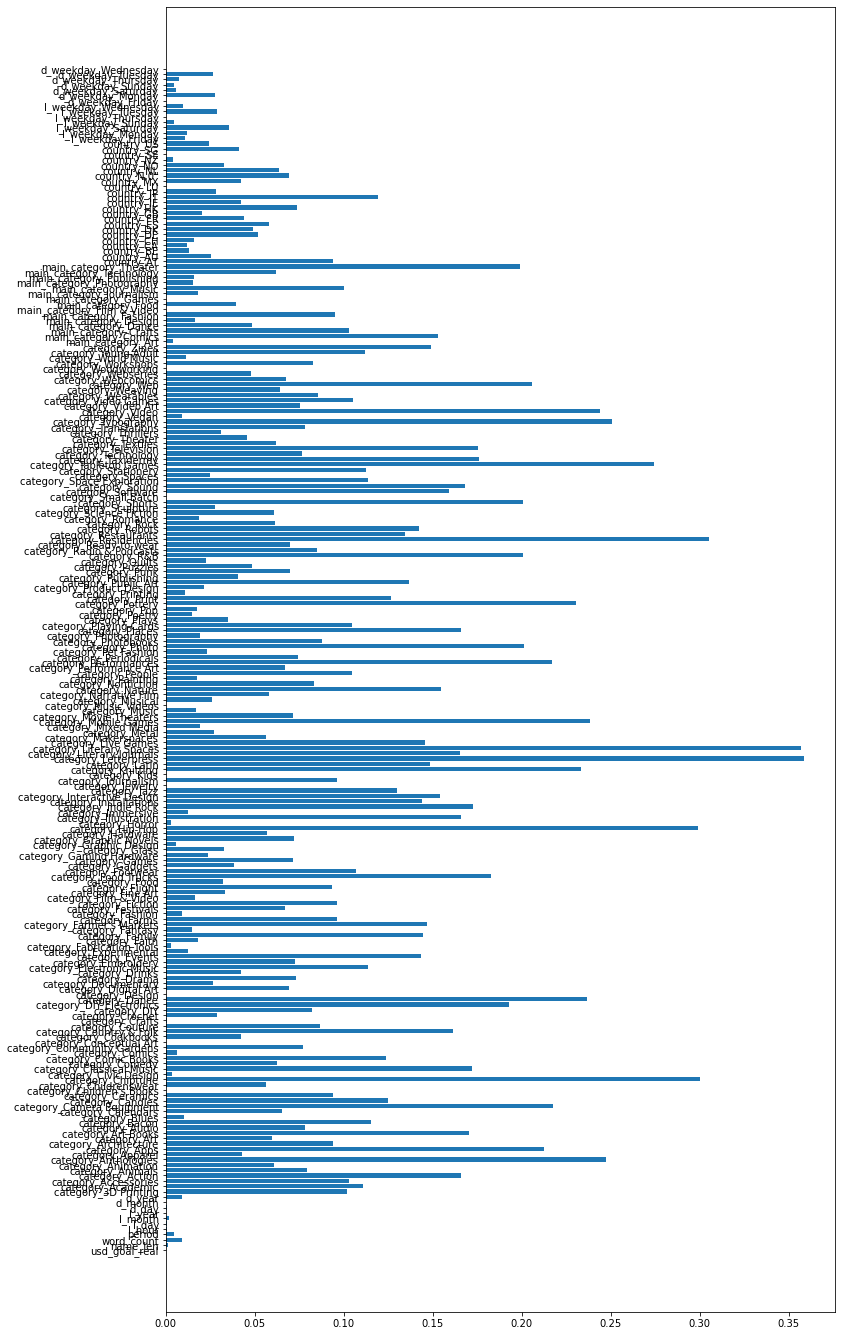

In [53]:
# 係数を棒グラフで表示
plt.figure(figsize=(12, 24)) 
plt.barh(np.arange(0, len(abs_coef)), abs_coef, tick_label=train_data.columns.values)
plt.show()

In [54]:
#特徴量を削減する
df_ks = df_ks.drop(train_data.columns[removed_idx], axis=1)

In [55]:
df_ks.describe()

,name_len,word_count,period,l_hour,l_day,l_month,d_day,d_year,category_3D Printing,category_Academic,category_Accessories,category_Action,category_Animals,category_Animation,category_Anthologies,category_Apparel,category_Apps,category_Architecture,category_Art,category_Art Books,category_Audio,category_Bacon,category_Blues,category_Calendars,category_Camera Equipment,category_Candles,category_Ceramics,category_Childrenswear,category_Chiptune,category_Civic Design,category_Classical Music,category_Comedy,category_Comic Books,category_Comics,category_Community Gardens,category_Cookbooks,category_Country & Folk,category_Couture,category_Crafts,category_Crochet,...,main_category_Fashion,main_category_Food,main_category_Journalism,main_category_Music,main_category_Photography,main_category_Publishing,main_category_Technology,main_category_Theater,country_AT,country_AU,country_BE,country_CA,country_CH,country_DE,country_DK,country_ES,country_FR,country_GB,country_HK,country_IE,country_IT,country_JP,country_MX,"country_N,0""",country_NL,country_NO,country_NZ,country_SG,country_US,l_weekday_Friday,l_weekday_Monday,l_weekday_Saturday,l_weekday_Sunday,l_weekday_Tuesday,l_weekday_Wednesday,d_weekday_Monday,d_weekday_Saturday,d_weekday_Sunday,d_weekday_Thursday,d_weekday_Tuesday
count,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.00000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.00000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,...,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000
mean,34.220335,5.631027,32.954889,13.087336,15.285421,6.416149,15.271491,2014.244543,0.001713,0.002343,0.008261,0.001872,0.000690,0.006672,0.002222,0.018591,0.015940,0.001936,0.02257,0.007444,0.001094,0.000546,0.000706,0.000874,0.001055,0.00114,0.000829,0.001260,0.000099,0.000802,0.007357,0.006235,0.007516,0.013812,0.000817,0.001372,0.012702,0.000684,0.012518,0.000455,...,0.059622,0.066493,0.012509,0.138537,0.029213,0.106868,0.081556,0.030880,0.001462,0.019947,0.001577,0.037296,0.001966,0.010360,0.002792,0.005647,0.007598,0.088802,0.001438,0.002059,0.007143,0.000069,0.004254,0.000633,0.007269,0.001755,0.003841,0.001369,0.788001,0.154810,0.161322,0.086088,0.055142,0.204126,0.178387,0.129728,0.158551,0.146768,0.158144,0.103648
std,15.961502,2.757329,12.713279,7.715452,8.814433,3.306967,9.038861,1.919260,0.041347,0.048345,0.090515,0.043230,0.026267,0.081411,0.047087,0.135074,0.125245,0.043953,0.14853,0.085958,0.033064,0.023354,0.026552,0.029557,0.032468,0.03374,0.028783,0.035478,0.009974,0.028308,0.085455,0.078716,0.086371,0.116710,0.028573,0.037013,0.111987,0.026152,0.111183,0.021332,...,0.236786,0.249143,0.111144,0.345464,0.168402,0.308945,0.273688,0.172993,0.038212,0.139820,0.039678,0.189486,0.044294,0.101254,0.052765,0.074935,0.086834,0.284458,0.037896,0.045332,0.084212,0.008327,0.065085,0.025155,0.084949,0.041853,0.061858,0.036972,0.408724,0.361724,0.367828,0.280494,0.228257,0.403062,0.382839,0.336004,0.365258,0.353876,0.364877,0.304803
min,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,2009.000000,0.000000,0.000000,0.000000,0.000000,0.0000

ホールドアウト法でデータを分け、標準化する

In [56]:
#ホールドアウト法で分ける
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234)

**※DEBUG　以下のコードは別の分析ソフトで検証するために外部出力するためのコード（通常はコメントアウト）**

In [57]:
"""
# 学習データとテストデータを検証用に外部出力して保存する
np.savetxt('x_train.csv',X_train,delimiter=',')
print('train.csv done.')
np.savetxt('x_test.csv',X_test,delimiter=',')
print('test.csv done.')
np.savetxt('y_train.csv',y_train,delimiter=',')
print('train.csv done.')
np.savetxt('y_test.csv',y_test,delimiter=',')
print('test.csv done.')
"""

"\n# 学習データとテストデータを検証用に外部出力して保存する\nnp.savetxt('x_train.csv',X_train,delimiter=',')\nprint('train.csv done.')\nnp.savetxt('x_test.csv',X_test,delimiter=',')\nprint('test.csv done.')\nnp.savetxt('y_train.csv',y_train,delimiter=',')\nprint('train.csv done.')\nnp.savetxt('y_test.csv',y_test,delimiter=',')\nprint('test.csv done.')\n"

In [60]:
#標準化
std_scaler = StandardScaler() 

# 学習用データ
X_train = std_scaler.fit_transform(X_train)
# テスト用データ
X_test = std_scaler.transform(X_test)

# 5.モデルを学習・評価する


# 複数モデルを学習して比較する

In [ ]:
models = {
    #'SDGClassifier' : SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=0, tol=1e-3),
    'SDGClassifier_L1' : SGDClassifier(loss='log', penalty='l1', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3),
    'DecisionTree': DecisionTreeClassifier(criterion='gini', max_depth=10, min_samples_leaf=4, min_samples_split=4, random_state=1234),
    #'RandomForest': RandomForestClassifier(n_estimators=10, max_depth=4, criterion="gini", min_samples_leaf=4, min_samples_split=4, random_state=1234),
    #0.683 'RandomForest_none_10': RandomForestClassifier(n_estimators=10, max_depth=None, criterion="gini", min_samples_leaf=4, min_samples_split=4, random_state=1234),
    #0.686 'RandomForest_none_15': RandomForestClassifier(n_estimators=15, max_depth=None, criterion="gini", min_samples_leaf=4, min_samples_split=4, random_state=1234),
    #'RandomForest_none_15_leaf2': RandomForestClassifier(n_estimators=15, max_depth=None, criterion="gini", min_samples_leaf=2, min_samples_split=4, random_state=1234),
    'RandomForest_none_100_0': RandomForestClassifier(n_estimators=100, max_depth=None, criterion="entropy", min_samples_leaf=4, min_samples_split=4, random_state=1234),
    #'RandomForest_none_20_1': RandomForestClassifier(n_estimators=120, max_depth=None, criterion="entropy", min_samples_leaf=4, min_samples_split=4, random_state=1234),
    #'RandomForest_none_20_2': RandomForestClassifier(n_estimators=200, max_depth=None, criterion="entropy", min_samples_leaf=4, min_samples_split=4, random_state=1234),
    'AdaBoost': AdaBoostClassifier(DecisionTreeClassifier(criterion='gini', max_depth=None, min_samples_leaf=4, min_samples_split=4, random_state=1234), random_state=1234), 
    #'AdaBoost_': AdaBoostClassifier(DecisionTreeClassifier(max_depth=3, min_samples_leaf=2, min_samples_split=2, random_state=1234, criterion="gini"), n_estimators=10, random_state=1234),
    #'KNeighborsClassifier' : KNeighborsClassifier(n_neighbors=6),
    'Bagging': BaggingClassifier(DecisionTreeClassifier(random_state=1234), n_estimators=100, random_state=0),
    #'Bagging_AdaBoost': AdaBoostClassifier(BaggingClassifier(GradientBoostingClassifier(random_state=0), n_estimators=100, random_state=0), random_state=0),
    'GradientBoost': GradientBoostingClassifier(min_samples_split=5, min_samples_leaf=50, max_depth=80, learning_rate=0.2, random_state=1234),
    #'Bagging_Gradientboost':BaggingClassifier(GradientBoostingClassifier(random_state=0), n_estimators=100, random_state=0)
}

# モデル構築
scores = {}
for model_name, model in models.items():
    print(model_name + " start.")
    model.fit(X_train, y_train)
    scores[(model_name, 'train_score')] = model.score(X_train, y_train)
    scores[(model_name, 'test_score')] = model.score(X_test, y_test)
    print(model_name + " done. " + np.str(scores[(model_name, 'test_score')]))

# 結果を表示
pd.Series(scores).unstack()

SDGClassifier_L1 start.
SDGClassifier_L1 done. 0.6704454661943168
DecisionTree start.
DecisionTree done. 0.6681239164845104
RandomForest_none_100_0 start.
RandomForest_none_100_0 done. 0.6907967136504108
AdaBoost start.
AdaBoost done. 0.6341448707318912
Bagging start.
Bagging done. 0.6835305645586794
GradientBoost start.


## グリッドサーチによるハイパーパラメータ最適化
上記結果からもっとも高いAccuracyのモデルでグリッドサーチによりハイパーパラメータを最適化する

In [72]:
#from sklearn.grid_search import GridSearchCV
from mpl_toolkits.mplot3d import Axes3D

mod1J1 =RandomForestClassifier(n_estimators=100, max_depth=None, criterion="entropy", min_samples_leaf=4, min_samples_split=4, random_state=1234)
paramJ1_1 = {'n_estimators': list(range(20, 100, 200)),
             'learning_rate': list(np.arange(0.05, 0.20, 0.02)),
             'criterion':["entropy", "gini"]
             }
# scoringをaccuracyとする
gsearch1 = GridSearchCV(estimator = mod1J1, 
                        param_grid = paramJ1_1, 
                        cv = 5, 
                        n_jobs=4, 
                        scoring = 'accuracy')
gsearch1.fit(X_train, y_train)

print(gsearch1.best_estimator_)
print(gsearch1.best_index_)
print(gsearch1.best_params_)
print(gsearch1.best_score_)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.2, loss='deviance', max_depth=5,
                           max_features='sqrt', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=50, min_samples_split=5,
                           min_weight_fraction_leaf=0.0, n_estimators=20,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=0.8, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
15
{'learning_rate': 0.2, 'n_estimators': 20}
0.6682445515526749


best_estimator_:  
best_index_:69  
best_params_:{'learning_rate': 0.12000000000000001, 'n_estimators': 80}  
best_score_:0.6569988984827487  


## 最適パラメータを用いて再学習する

In [ ]:
#最適パラメータを用いて識別する
model_best = RandomForestClassifier(n_estimators=100, max_depth=None, criterion="entropy", min_samples_leaf=4, min_samples_split=4, random_state=1234)
# モデル構築
scores = {}
print("model_best start.")
model_best.fit(X_train, y_train)
scores[("model_best", 'train_score')] = model.score(X_train, y_train)
scores[("model_best", 'test_score')] = model.score(X_test, y_test)
print("model_best" + " done. " + np.str(scores[("model_best", 'test_score')]))

# 結果を表示
pd.Series(scores).unstack()

In [76]:
# テストデータに対する予測
y_est = models["RandomForest_none_100_0"].predict(X_test)
# 確率値
y_est_proba = models["RandomForest_none_100_0"].predict_proba(X_test)

# 対数尤度を表示
# log_lossという関数は、負の対数尤度を返す
# normalizeという引数をTrueにすると、合計の対数尤度ではなく平均の対数尤度が計算される
print('対数尤度 = {:.3f}'.format(- log_loss(y_test, y_est_proba, normalize=False))) 
# 正答率を計算
accuracy =  accuracy_score(y_test, y_est)
print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy))

# Precision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_est)

# Precision, Recall, F1-scoreを表示
print('適合率（Precision） = {:.3f}%'.format(100 * precision[1]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[1]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[1]))

対数尤度 = -38320.397
正答率（Accuracy） = 69.080%
適合率（Precision） = 65.621%
再現率（Recall） = 49.205%
F1値（F1-score） = 56.239%


## ニューラルネットワークで学習、評価する

In [ ]:
from tensorflow.compat.v1.keras import Sequential
from tensorflow.compat.v1.keras.layers import Dense, Dropout, Activation
from tensorflow.compat.v1.keras.optimizers import SGD,RMSprop, Adagrad, Adadelta, Adam

model = Sequential()
model.add(Dense(6, activation='tanh', input_dim=205))
model.add(Dense(5, activation='relu', input_dim=6))

model.add(Dense(3, activation='softmax'))#最終層のactivationは変更しないこと

# ------ 最適化手法 ------
sgd = SGD(lr=0.01, momentum=0.9, nesterov=False)
# rms = RMSprop(lr=0.01)
# adag = Adagrad(lr=0.01)
# adad = Adadelta(lr=0.01)
# adam = Adam(lr=0.01)
# -----------------------------

model.compile(loss='binary_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

In [ ]:
# 計算の実行
fit = model.fit(X_train, y_train,
          epochs=100,
          batch_size=20,validation_data=(X_test, y_test))

# 各epochにおける損失と精度をdfに入れる
df = pd.DataFrame(fit.history)

# グラフ化
df[["loss", "val_loss"]].plot()
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

df[["accuracy", "val_accuracy"]].plot()
plt.ylabel("acc")
plt.xlabel("epoch")
plt.ylim([0,1.0])
plt.show()

# 6.まとめ




DAY2課題時で最もAccuracyが高かった結果

**DAY2：ロジスティック回帰＋標準化+L1正規化＋ホールドアウト法**
* 学習データ
 * 対数尤度 = -202265.615
 * 正答率（Accuracy） = 64.286%
 * 適合率（Precision） = 55.608%
 * 再現率（Recall） = 57.480%
 * F1値（F1-score） = 56.529%

* テストデータ
 * 対数尤度 = -51125.970
 * 正答率（Accuracy） = 63.954%
 * 適合率（Precision） = 55.137%
 * 再現率（Recall） = 57.248%
 * F1値（F1-score） = 56.172%

**DAY3:ランダムフォレスト**
* 汎化性能
 * 対数尤度 = -38320.397
 * 正答率（Accuracy） = 69.080%
 * 適合率（Precision） = 65.621%
 * 再現率（Recall） = 49.205%
 * F1値（F1-score） = 56.239%

DAY2のロジスティック回帰と比較して、DAY3ランダムフォレストで**Accuracyが63.954%から69.080%へと5.126ポイント上昇**した


# 7.課題

Accuracy目標の80％に対して、約11％不足している